In [19]:
import requests
from IPython.core.display import HTML

# PCA for shape generation

**Mandatory assignment 2**
This is the second mandatory assignment, to be submitted on LearnIT as a Jupyter Notebook containing your implementation and notes by the deadline specified on [LearnIT](https://learnit.itu.dk/)
. Details on the submission process can be found [here](https://iml.itu.dk/01-about_the_course/01-AboutTheCourse.html)
.
In this assignment, PCA will be applied to generate face shapes. The objective is to explore the relationship between points in the latent space and their corresponding representations in the data space.

<div style="float: none; width: 100%; justify-content: start" class="block is-clearfix">


<article class="message">
    <div class="message-body">
        <strong>Overview of mandatory tasks</strong>
        <ul style="list-style: none;">
            <li>
            <a href="#prep">Task 1: Data inspection</a>
            </li>
            <li>
            <a href="#get_pca">Task 2: Get principal compontents</a>
            </li>
            <li>
            <a href="#gen">Task 3: Base face</a>
            </li>
            <li>
            <a href="#gen_reflect">Task 4: Base face reflections </a>
            </li>
            <li>
            <a href="#c">Task 5: Investigate variations in latent space</a>
            </li>
            <li>
            <a href="#interpolate">Task 6: Interpolation between two faces</a>
            </li>
            <li>
            <a href="#reflect">Task 7: Reflection</a>
            </li>
            <li>
            <a href="#correlation_eigen">Task 8: Eigenvalues and eigenvectors of correlat…</a>
            </li>
            <li>
            <a href="#Dimensionality_red">Task 9: Out of distribution generation</a>
            </li>
        </ul>
    </div>
</article>



</div>


**Important**
Solve the in-class exercise about PCA **before starting on this assignment**. You are of course welcome to ask about both the in-class exercise and the assignment. 

## Data
The dataset used for the assigment consist of 120 landmarks (2D points) of faces (data space). A face consists of 73 (x,y)-coordinate pairs, i.e. 146 featues in total.

---
**Task 1 (easy): Data inspection👩‍💻**
1. Run the cell below to load libraries, the data and to  visualize the first 6 sample face shapes.


---

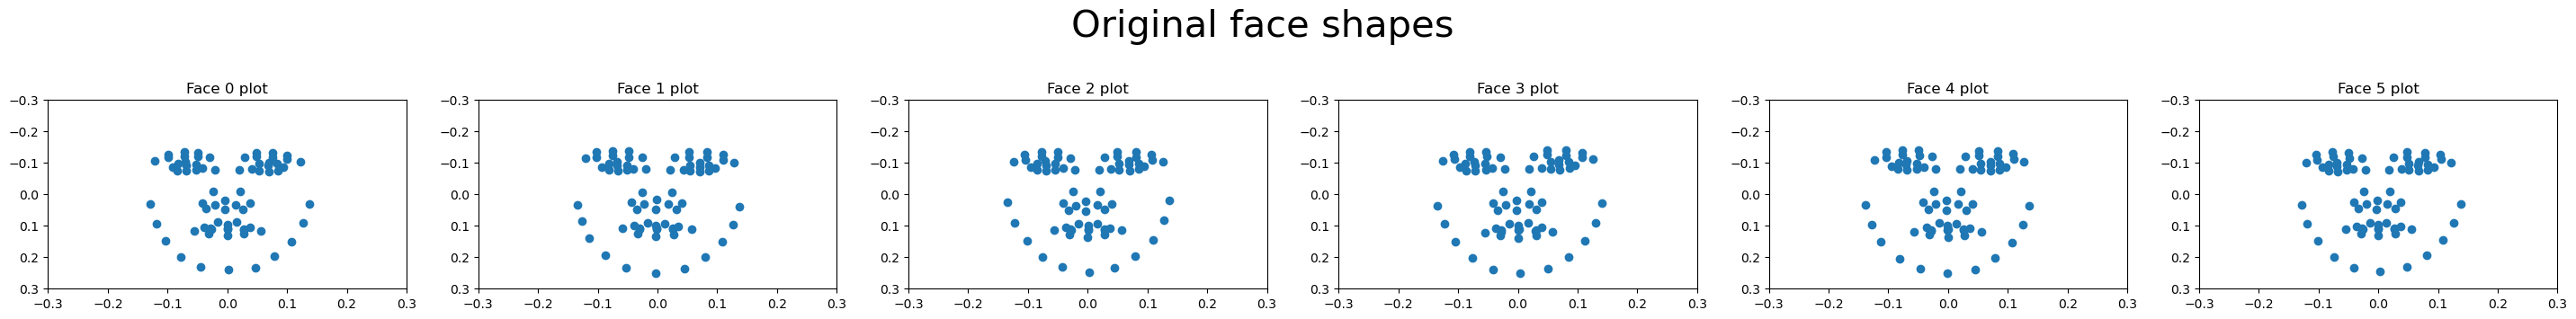

In [20]:
## Importing libraries
import matplotlib.pyplot as plt
import numpy as np
import scipy
from pca_utils import *
import os
from glob import glob

path = './db/'
shapes, _ = face_shape_data(path)

plot_many_faces(shapes[:6],"Original face shapes");

## PCA implementation
The following tasks are about using the implementation of PCA from the in-class exercise on the face shape dataset. 

---
**Task 2 (easy): Get principal compontents👩‍💻**
1. Complete the `get_principal_components`
 function so that it returns all principal components `comp`
, eigenvalues `val`
 and mean vector `mu`
, given the dataset `shapes`
.
2. Use the `get_principal_components`
 function to calculate the principal components (`comp`
) for the face dataset.
3. How many components are needed to retain $50\%$, $60\%$, $80\%$, $95\%$ of the total variation?
4. Set $k=5$ components. How much of the total variance is retained?
5. Implement the function `transform_to_latent_space`
  according to the comments in the cell below using  $\mathbf{a} = \mathbf{\Phi_k}^\top(\mathbf{x}-\mathbf{\mu})$ .
6. Implement the function `transform_from_latent_space`
  according to the comments in the cell below using $x  = \mathbf{\Phi_k} \mathbf{a} + \mathbf{\mu}$ . 
7. Run the cell below to map $6$ face shapes to the latent space and back to the original data space. The `plot_many_faces`
 function is used to display both the original and the restored face shapes.
8. Visually inspect the figures and describe the reconstruction error.


---

Components needed for each threshold: {0.5: 2, 0.6: 2, 0.8: 4, 0.95: 8}
Variance retained with 5 components: 0.87


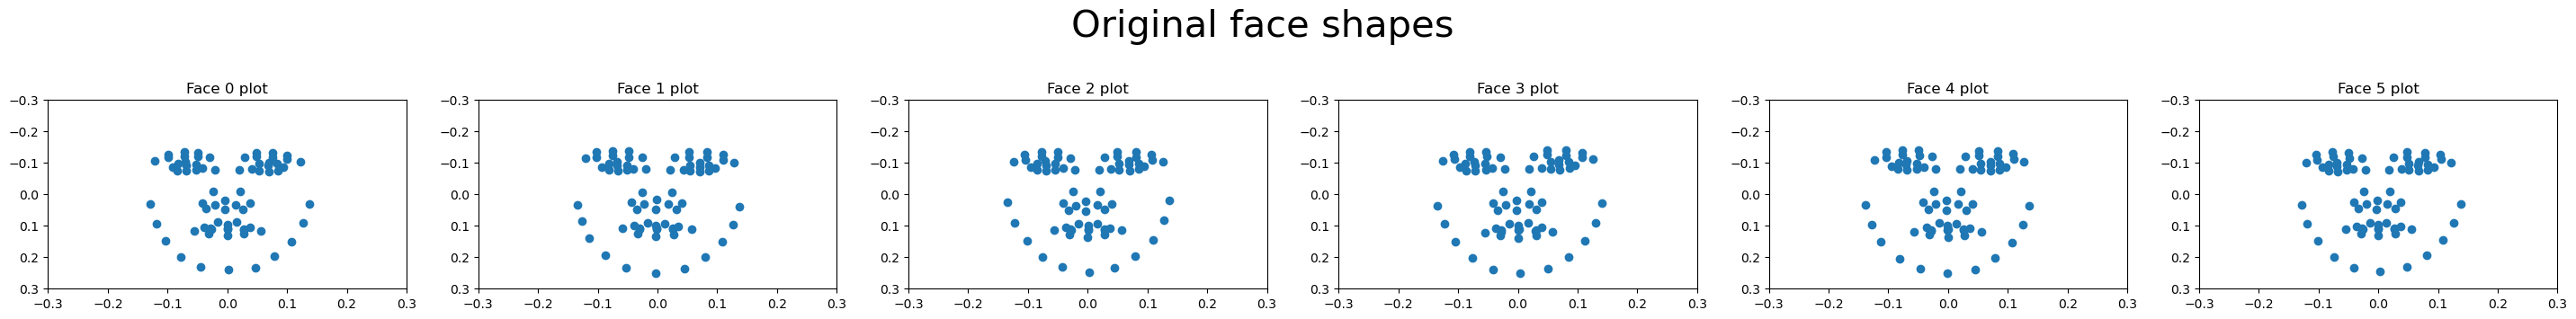

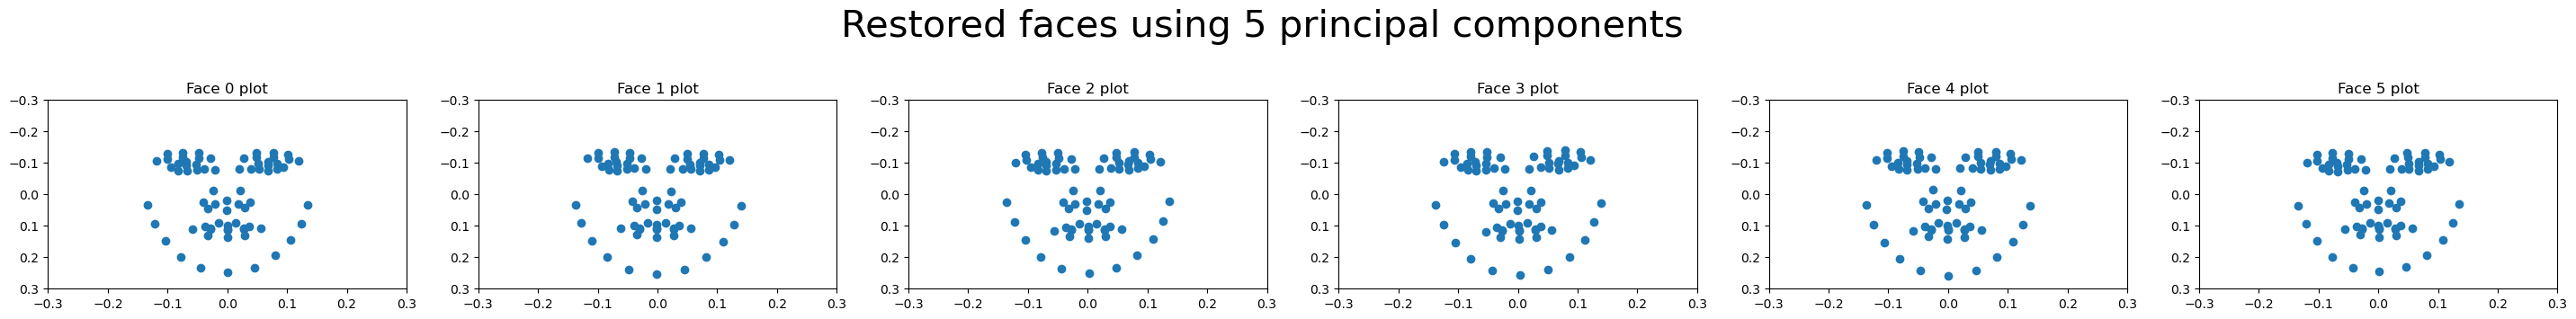

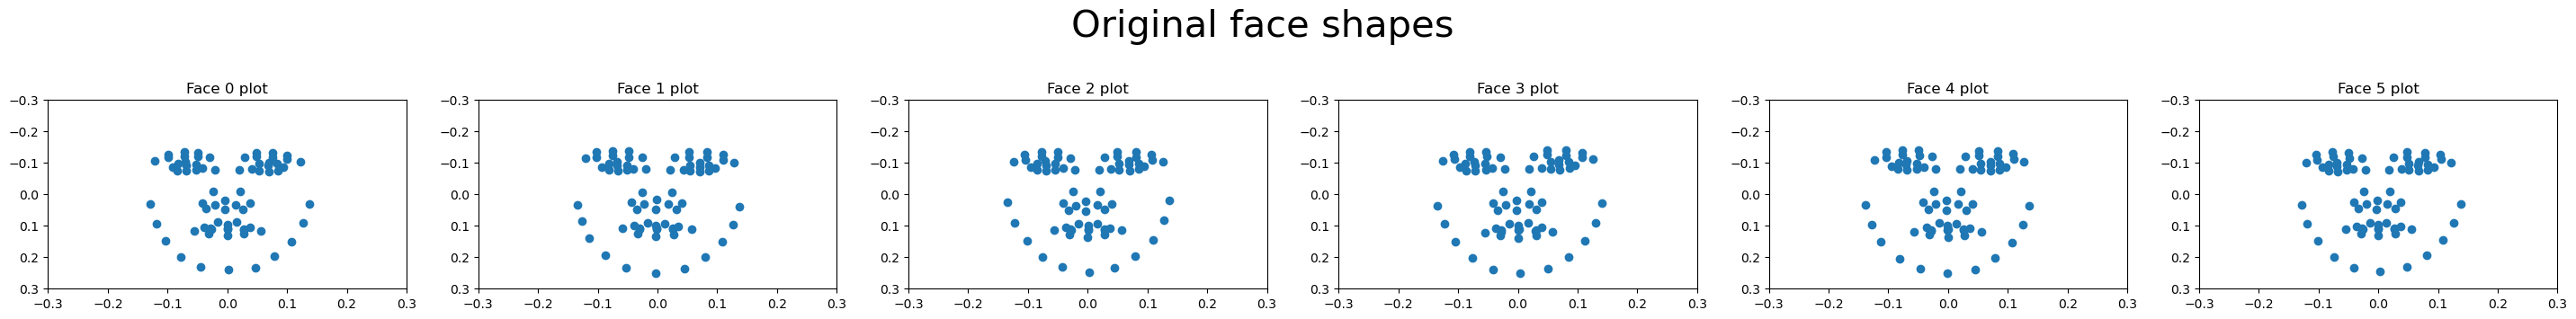

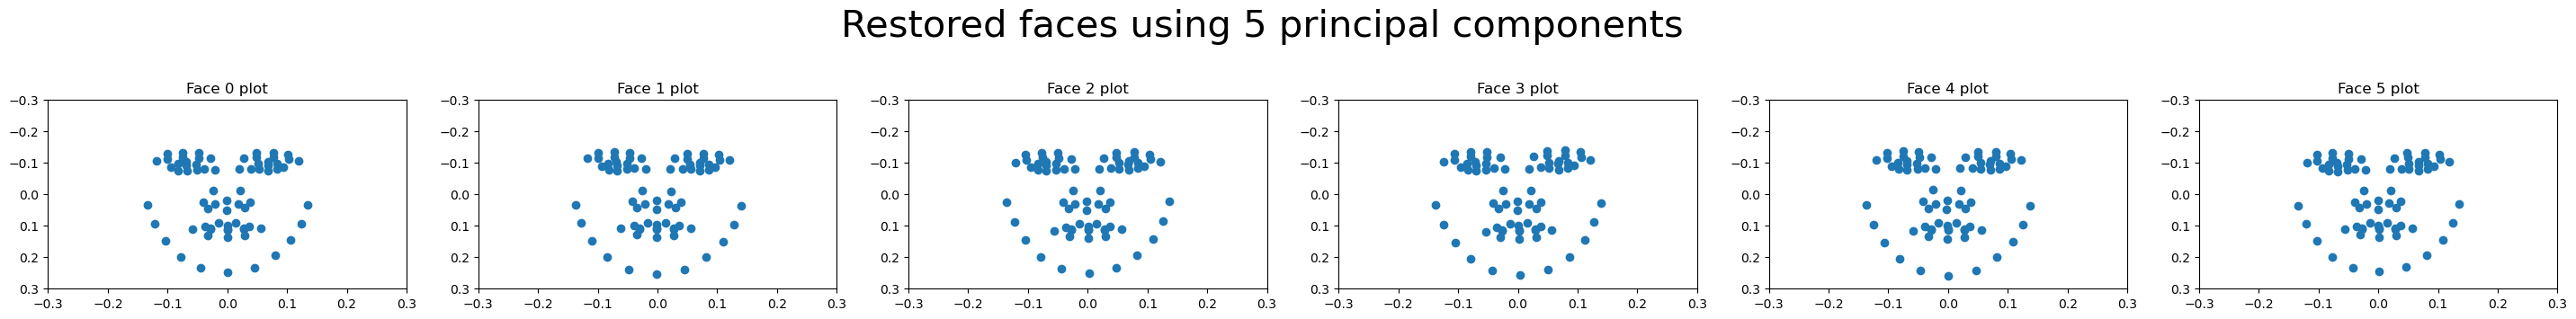

In [21]:
# 1
def get_principal_components(X):
    """Calculates principle components for X.

    Args:
        X: The dataset. An NxD array were N are the number of samples and D are
        the number of features.

    Returns:
        Tuple (components, eigenvalues, mu) where components is a DxD matrix of
        principle components, eigenvalues is a D-element vector of
        corresponding eigenvalues, and mu is a D-element array containing the mean
        vector.
    """
    # Calculate the mean vector
    mu = np.mean(X, axis=0)
    # Center the data by subtracting the mean
    X_centered = X - mu
    # Compute the covariance matrix
    C = np.cov(X_centered, rowvar=False)
    # Calculate eigenvalues and eigenvectors of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eigh(C)
    # Sort eigenvalues and eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]
    # Return the principal components (eigenvectors), eigenvalues, and mean vector
    return eigenvectors, eigenvalues, mu


# 2, 3 and 4
# Get the principal components for the dataset and transform the faces to feature space.
comp, val, mu = get_principal_components(shapes)

# write code for finding the cumulative proportional variance here
cumulative_variance = np.cumsum(val) / np.sum(val)

# Find the number of components needed for each threshold
thresholds = [0.50, 0.60, 0.80, 0.95]
components_needed = [np.searchsorted(cumulative_variance, t) + 1 for t in thresholds]
components_needed_dict = dict(zip(thresholds, components_needed))

print("Components needed for each threshold:", components_needed_dict)


# selecting 5 components 
n_components = 5
retained_variance = cumulative_variance[n_components - 1]  # Since indices are zero-based
print(f"Variance retained with {n_components} components: {retained_variance:.2f}")


# 5
def transform_to_latent_space(X, principle_components, mu):
    """Transforms X to an k-dimensional space where k is the number of
    principle_components.

    Args:
        X: The dataset. An NxD array were N are the number of samples and D are
        the number of features.
        principle_components: An Dxk matrix containing the principle
        components.
        mu: A D-element array containing the mean vector.

    Returns:
        A Nxk array describing the transformed data.
    """
    # Center the data by subtracting the mean
    X_centered = X - mu
    # Project the centered data onto the principal components
    latent_space_data = np.dot(X_centered, principle_components)
    return latent_space_data

    
# 6  
def transform_from_latent_space(v, principle_components, mu):
    """Reverses the dimensionality reduction of v, a Nxk matrix where
    k is the number of principle components. The result is a NxM matrix.

    Args:
        v: The transformed dataset with size Nxk.
        principle_components: An Dxk matrix containing the principle
        components.
        mu: A Mx1 matrix containing the mean vector.

    Returns:
        An NxD array reconstruction of the original feature vectors X.
    """
    # Reconstruct the data by projecting back to data space and adding the mean
    reconstructed_data = np.dot(v, principle_components.T) + mu
    return reconstructed_data

    
# 7     
used = comp[:, :n_components]

# Plot original face shapes
plot_many_faces(shapes[:6], "Original face shapes")

# Transform to latent space and back to data space
transformed = transform_to_latent_space(shapes[:6], used, mu)
restored = transform_from_latent_space(transformed, used, mu)

# Plot reconstructed face shapes
plot_many_faces(restored, "Restored faces using 5 principal components")



# transforming and reconstructing the 6 first faces in the dataset
plot_many_faces(shapes[:6],"Original face shapes")
transformed = transform_to_latent_space(shapes[:6], used, mu)
restored = transform_from_latent_space(transformed, used, mu)
plot_many_faces(restored,"Restored faces using 5 principal components")

# 8
#Generally, as k increases, the reconstruction error decreases, 
#making the restored faces closer to the originals. 
# With k=5, some minor details may be lost, but overall face structure should be well-preserved.

## Using PCA for shape generation
The principal components can be used to generate new samples $\mathbf{x}$ in data space by transforming a point in latent space according to 
$$\mathbf{x} = \Phi_{k} a + \mu$$
 where $\Phi_{k}$ is the matrix of k eigenvectors, $\mathbf{a}\in\mathbb{R}^{k}$ is a vector in latent space, and $\mu\in\mathbb{R}^{D}$ is the mean vector of the original data features in  the data space.

$$

{\Phi_k} = \begin{bmatrix} | & | & & | \\ {v}_1 & {v}_2 & \cdots & {v}_k \\ | & | & & | \end{bmatrix}

$$
The variance of the data in a given direction can be used to constrain the values of the elements of the vector $\mathbf{a}$ in latent space, assuming that the data follows a (multivariate) normal distribution. In a multivariate normal distribution each direction $v_i$ is also normally distributed. Each element $a_i$ can be constrained to be within the observed variance in direction $v_i$. The variance $\sigma^2$ in the direction of $v_i$ is given by the eigenvalue $\lambda_i$, so the standard deviation is  $\sigma_i = \sqrt{\lambda_i}$.
In a 1D normal distribution (with mean $\mu$ and standard deviation $\sigma$), the area under the Gaussian curve between $\pm 3\sigma$ contains $99.7\%$ of the data (see [Figure 1](#normal) ). Thus, constraining each element $a_i$ to the interval $[-3\sigma_i, 3\sigma_i]$ will cover $99.7\%$ of the variance in the direction of $v_i$. 
<div class="has-text-centered">
<figure class="image is-inline-block" id="normal">

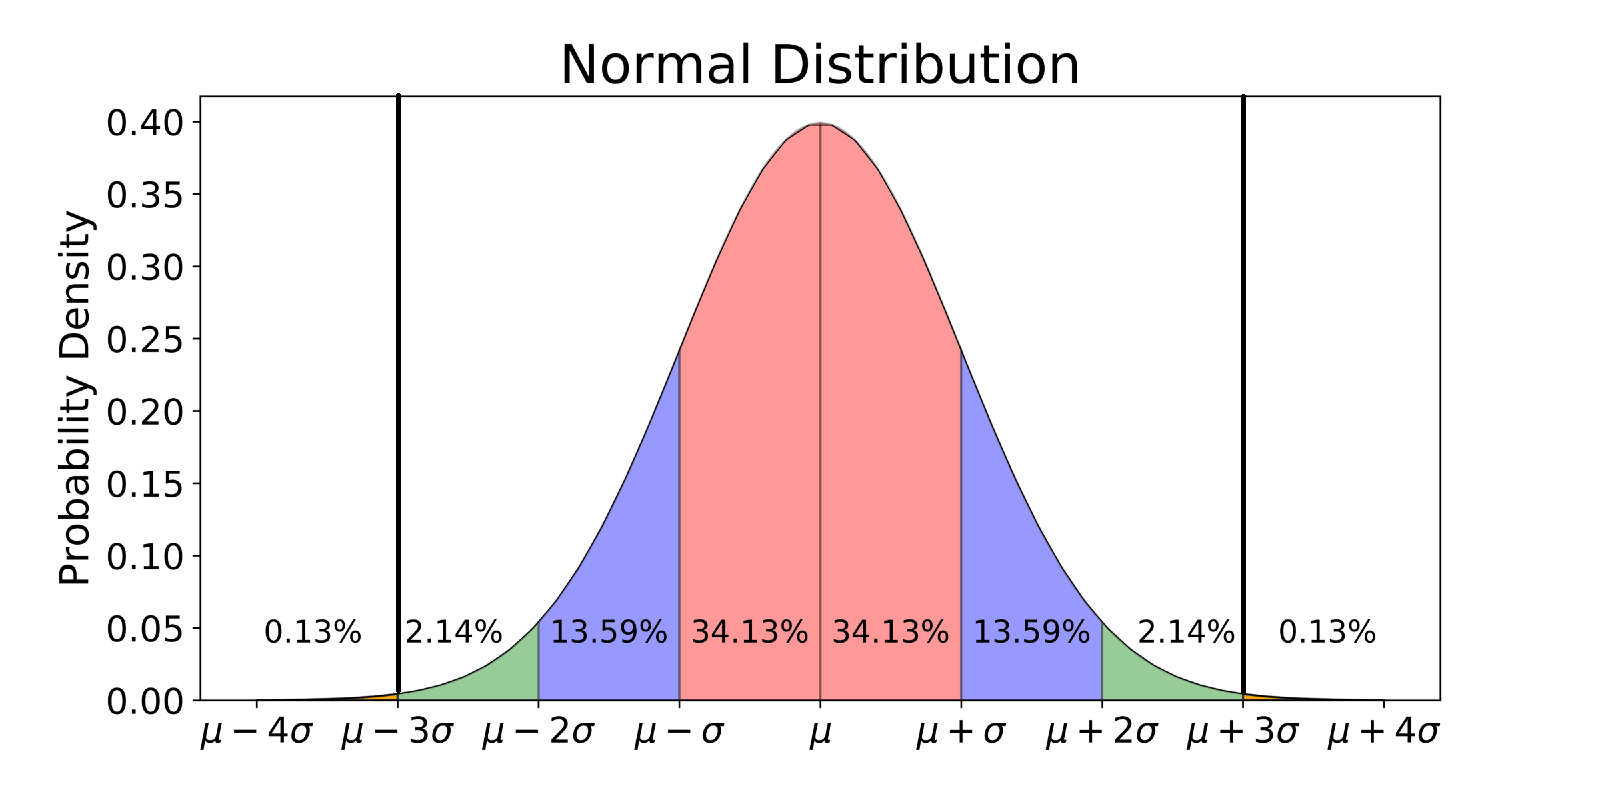

<figcaption class="figure-caption has-text-centered">Figure 1: Illustration of a normal distribution. The vertical lines mark the region covering $99.7\%$ of the variance. The shaded regions indicate the
area of the distribution covered by 1, 2, 3, and 4, standard deviations
($\sigma$) respectively.
</figcaption>
</figure>
</div>

---
**Task 3 (medium): Base face👩‍💻**
1. **Generate vectors:** run the cell below to create the zero vector in latent space, i.e. $\mathbf{a} = [0, 0, \dots, 0]\in\mathbb{R}^5$.
2. **Shape generation:** use $\mathbf{x} = \mathbf{\Phi} \mathbf{a} + \mathbf{\mu}$ to generate a face (vector in real space) from the vector $\mathbf{a}$. Use the `plot_face`
 function to visualise the generated face.
3. Change the elements of $\mathbf{a}$ to the values below, where $\lambda_i$ is the i-th eigenvalue and plot the resulting shapes for each modification:    - $\mathbf{a} = [\lambda_1,0, 0, 0, 0]$ $\in\mathbb{R}^5$? 
    - $\mathbf{a} = [0,-3\lambda_2, 0, 0, 0]$ $\in\mathbb{R}^5$?




---

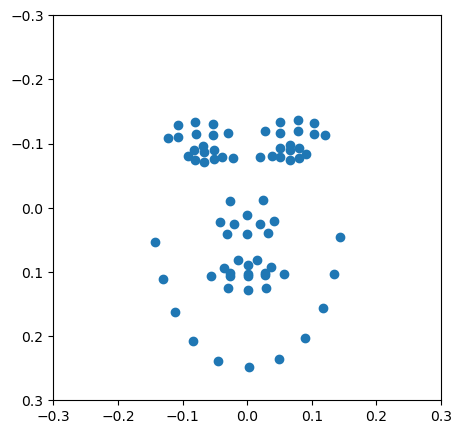

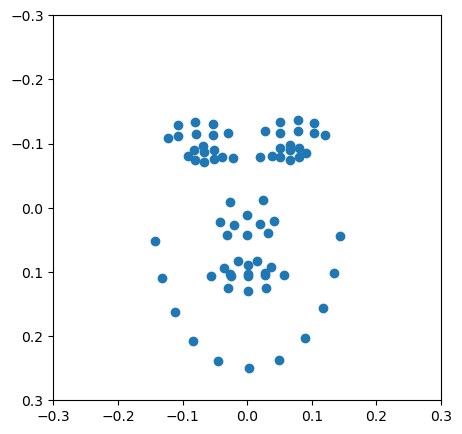

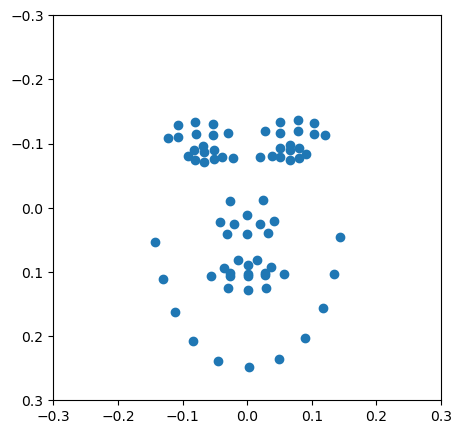

In [22]:
#1 Generate Zero Vector in Latent Space
a_zero_vector = np.array([0,0,0,0,0])

#2 Generate a Face Shape from the Zero Vector
# Select the first 5 principal components
Phi_k = comp[:, :5]

# Generate a face in data space from the zero vector in latent space
base_face = transform_from_latent_space(a_zero_vector.reshape(1, -1), Phi_k, mu)
plot_face(base_face[0])
# Reflection: The first generated face corresponds to the mean shape, as it uses a zero vector in latent space.

#3.1 Generate and Plot New Faces by Modifying the Vector a, setting the first element to lambda_1

# Set the first component of a to lambda_1
a_lambda1 = np.array([val[0],0,0,0,0])
# Generate the corresponding face in data space
face_lambda1 = transform_from_latent_space(a_lambda1.reshape(1, -1), Phi_k, mu)
plot_face(face_lambda1[0])

#3.2 Generate and Plot New Faces by Modifying the Vector a, setting the second element to -3 * sqrt(lambda_2)
a_neg3lambda2 = np.array([0,0,0,0,0])
a_neg3lambda2[1] = -3 * np.sqrt(val[1])

# Generate the corresponding face in data space
face_neg3lambda2 = transform_from_latent_space(a_neg3lambda2.reshape(1, -1), Phi_k, mu)
plot_face(face_neg3lambda2[0])

#Reflection - Modifying the vector 'a' by setting individual components to specific eigenvalues allows you to explore the variations introduced by each principal component, revealing how each component captures unique variations in the data.



---
**Task 4 (medium): Base face reflections 💡**
1. Use $\mathbf{x} = \Phi_{k} a + \mu$ to explain what the vector $a \in R^5$ represents if     - $\mathbf{a}= [0,0,0,0,0]$?
    - $\mathbf{a} = [\lambda_1,0, 0, 0, 0]$? 
    - $\mathbf{a} = [0,-3\lambda_2, 0, 0, 0]$?


2. Describe what face is generated and why.


---

## Task 4 reflection

**What the vector 𝑎 ∈ R^5 represents for each case:**

1. $\mathbf{a} = [0,0,0,0,0]$ represents a face with no variations. The mean shape is generated. Essentially, this is the "average" shape across all samples, as no variation is applied along any of the principal components.
2. $\mathbf{a} = [\lambda_1,0, 0, 0, 0]$ represents a face with a vertical shift of $\lambda_1$ units. Since this is the most significant direction of variation in the dataset, the generated face shape captures the most prominent way the faces deviate from the mean shape
3. $\mathbf{a} = [0,-3\lambda_2, 0, 0, 0]$ represents a face with a horizontal shift of $-3\lambda_2$ units. Pushes the shape three standard deviations away from the mean in the direction of the second component.

**What face is generated and why**

## Investigating principal components
The following tasks are about investigating properties of principal components.

---
**Task 5 (medium): Investigate variations in latent space👩‍💻**
1. **Varying the 1st component:** Let $\mathbf{a} \in \mathbb{R^5}$ be a vector in the latent space. Generate 5 different vectors where only the first element, $a_1$, varies, while the remaining elements, $a_2, a_3, a_4, a_5$, are set to 0. Use `np.linspace`
 to generate 5 evenly spaced values for $a_1$ in the interval $[-3\sigma_1, 3\sigma_1]$. For each value of $a_1$, generate a corresponding face and display all 5 faces in a plot. 

2. **More components:** Do the same for each of the remaining four components, i.e. $a_2$-$a_5$ leaving the others as 0. 

3. **Component analysis:** Describe how each principal component changes the face shape (for example, the first component may change the length of the face). 



---

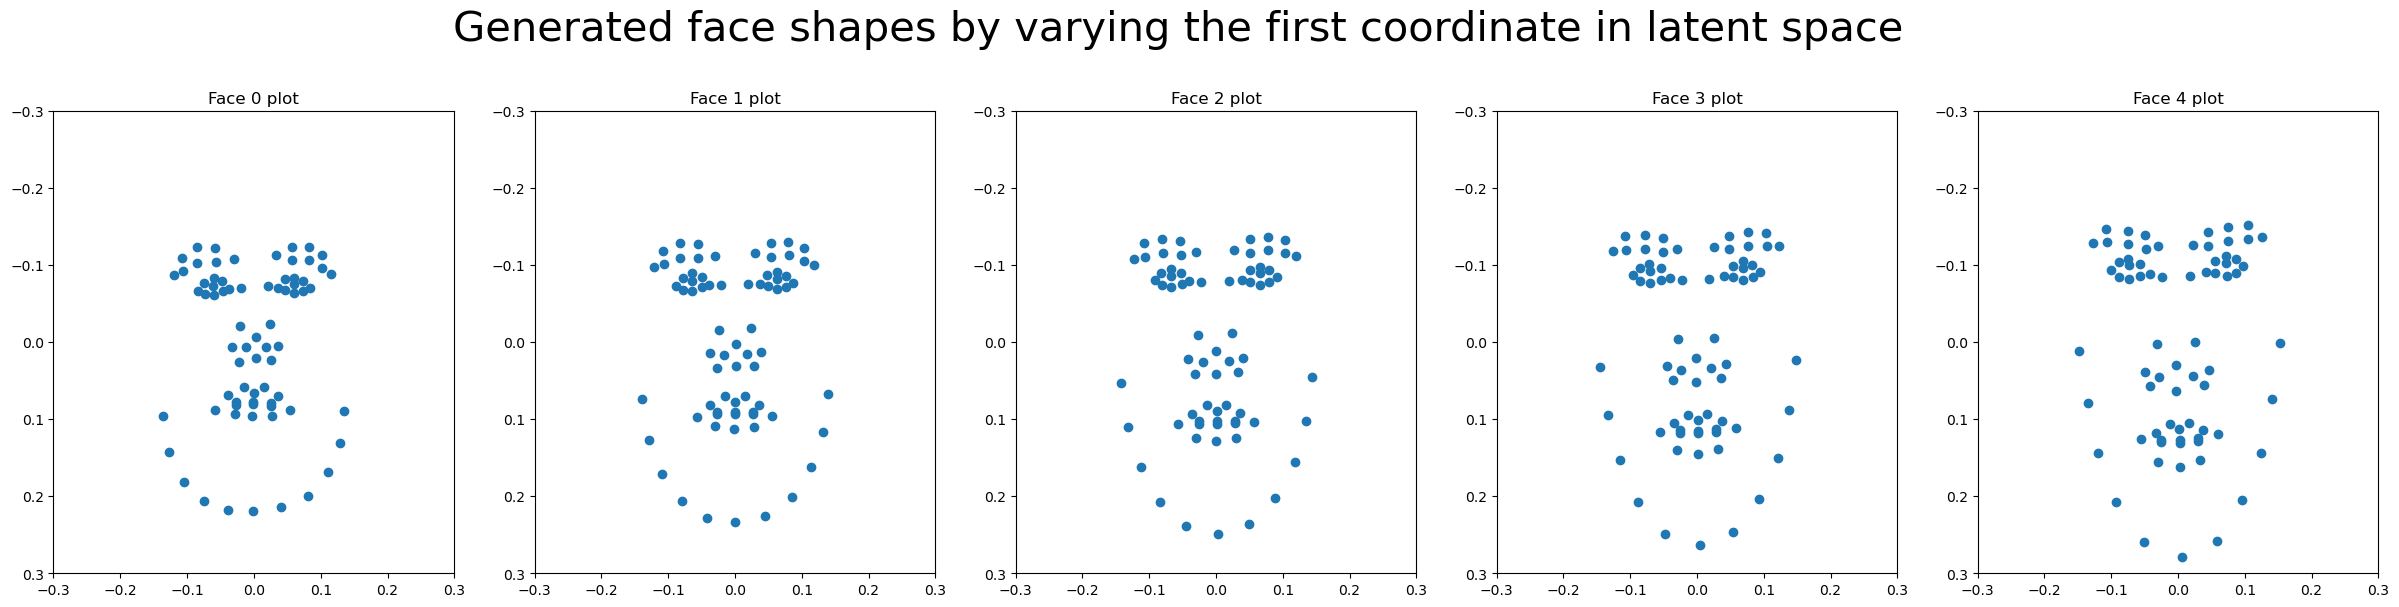

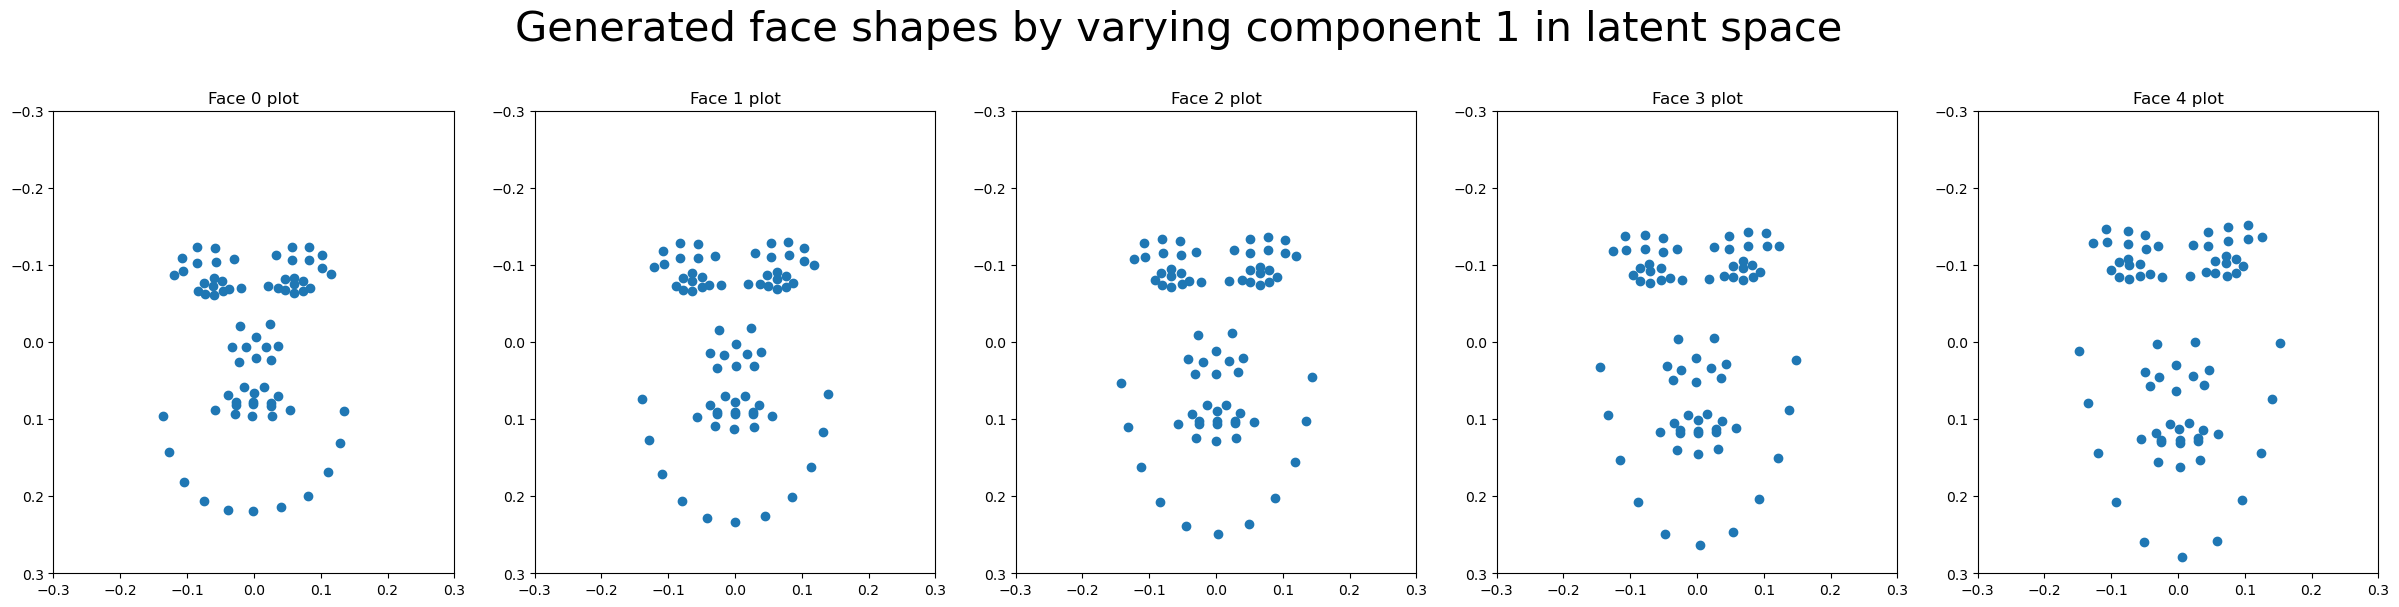

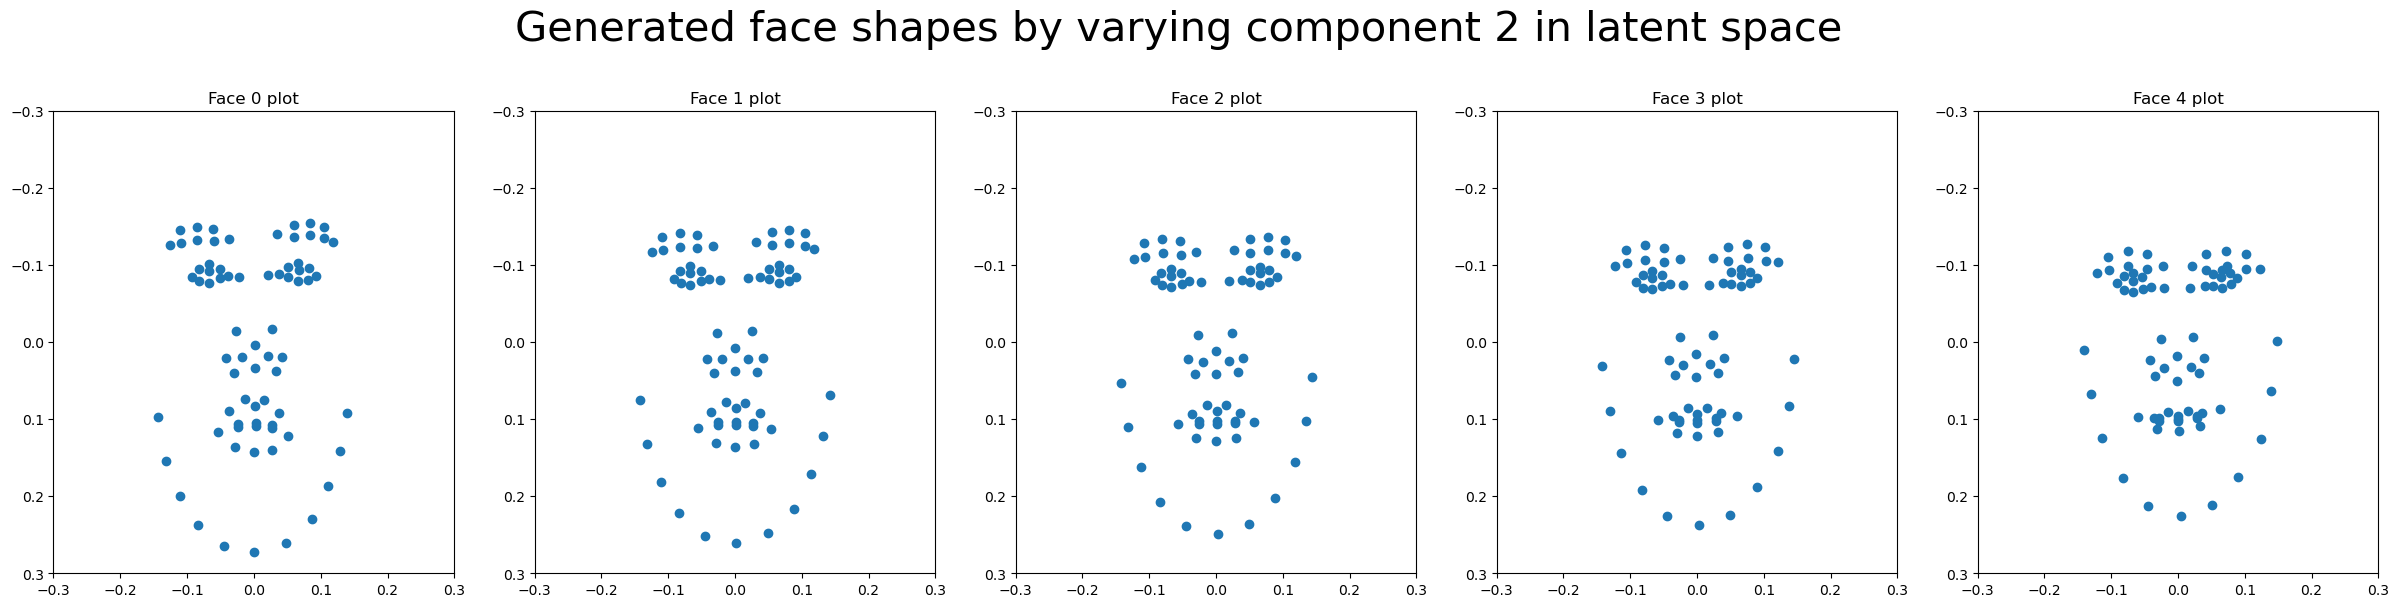

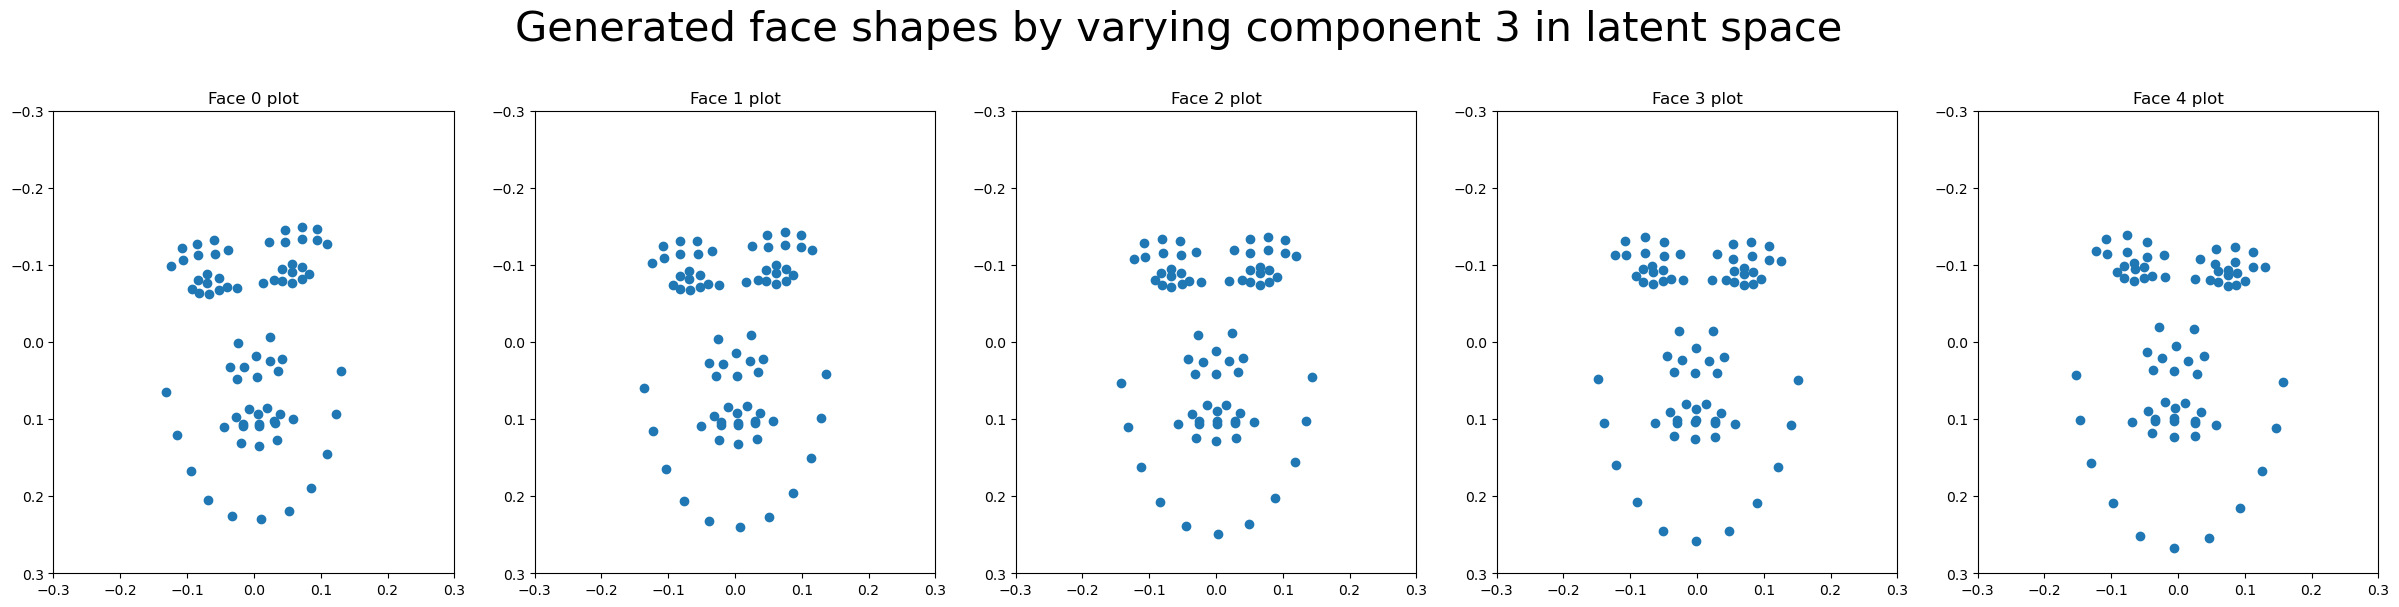

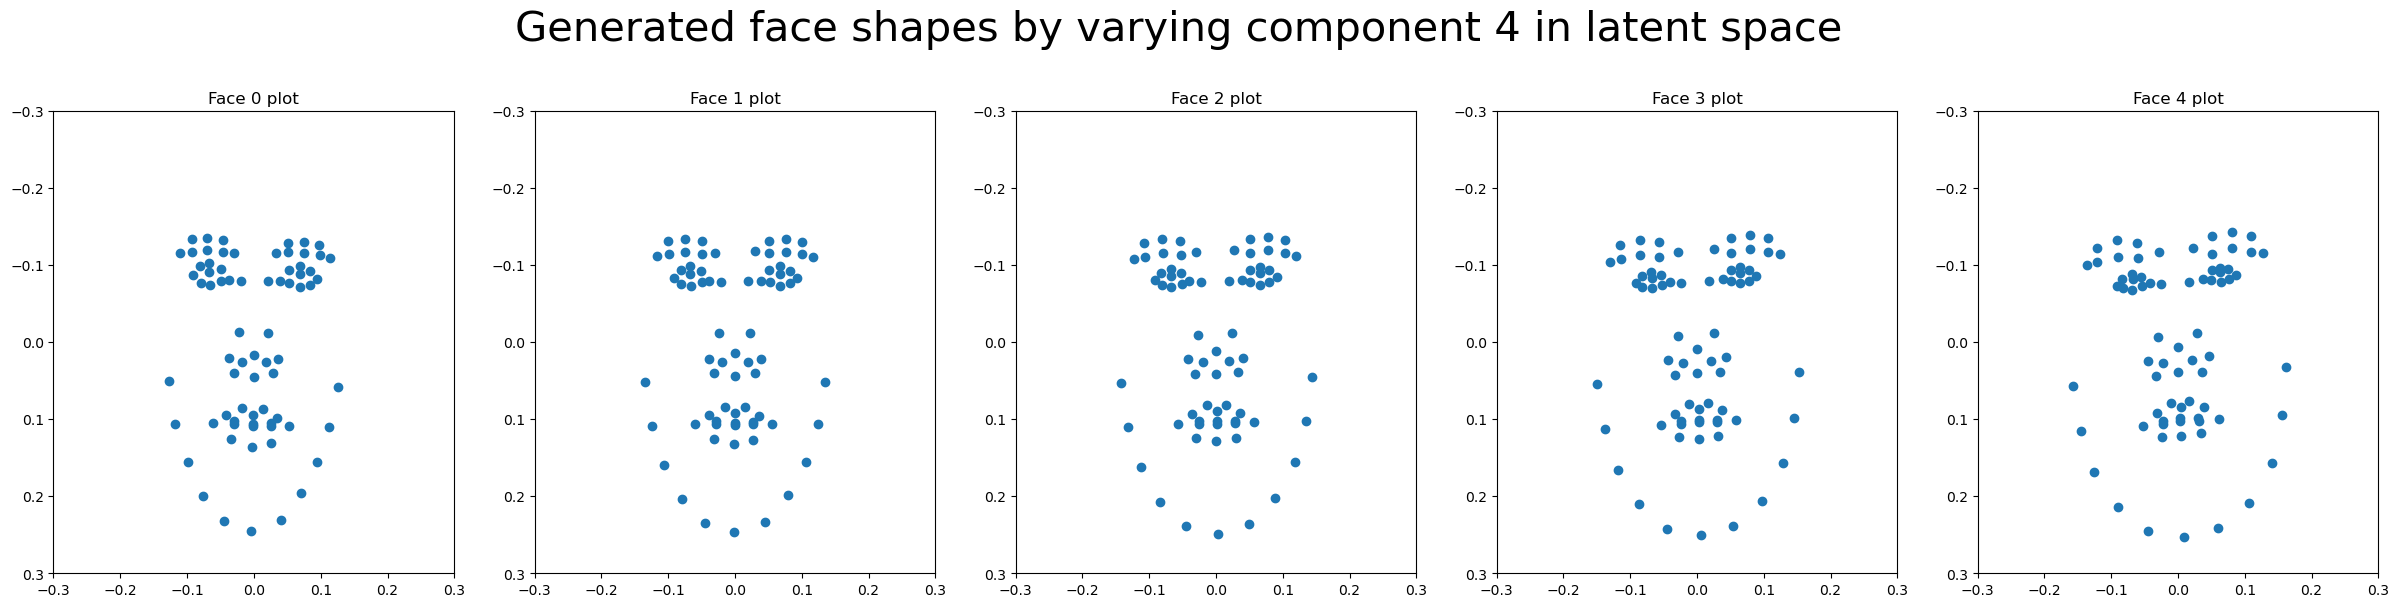

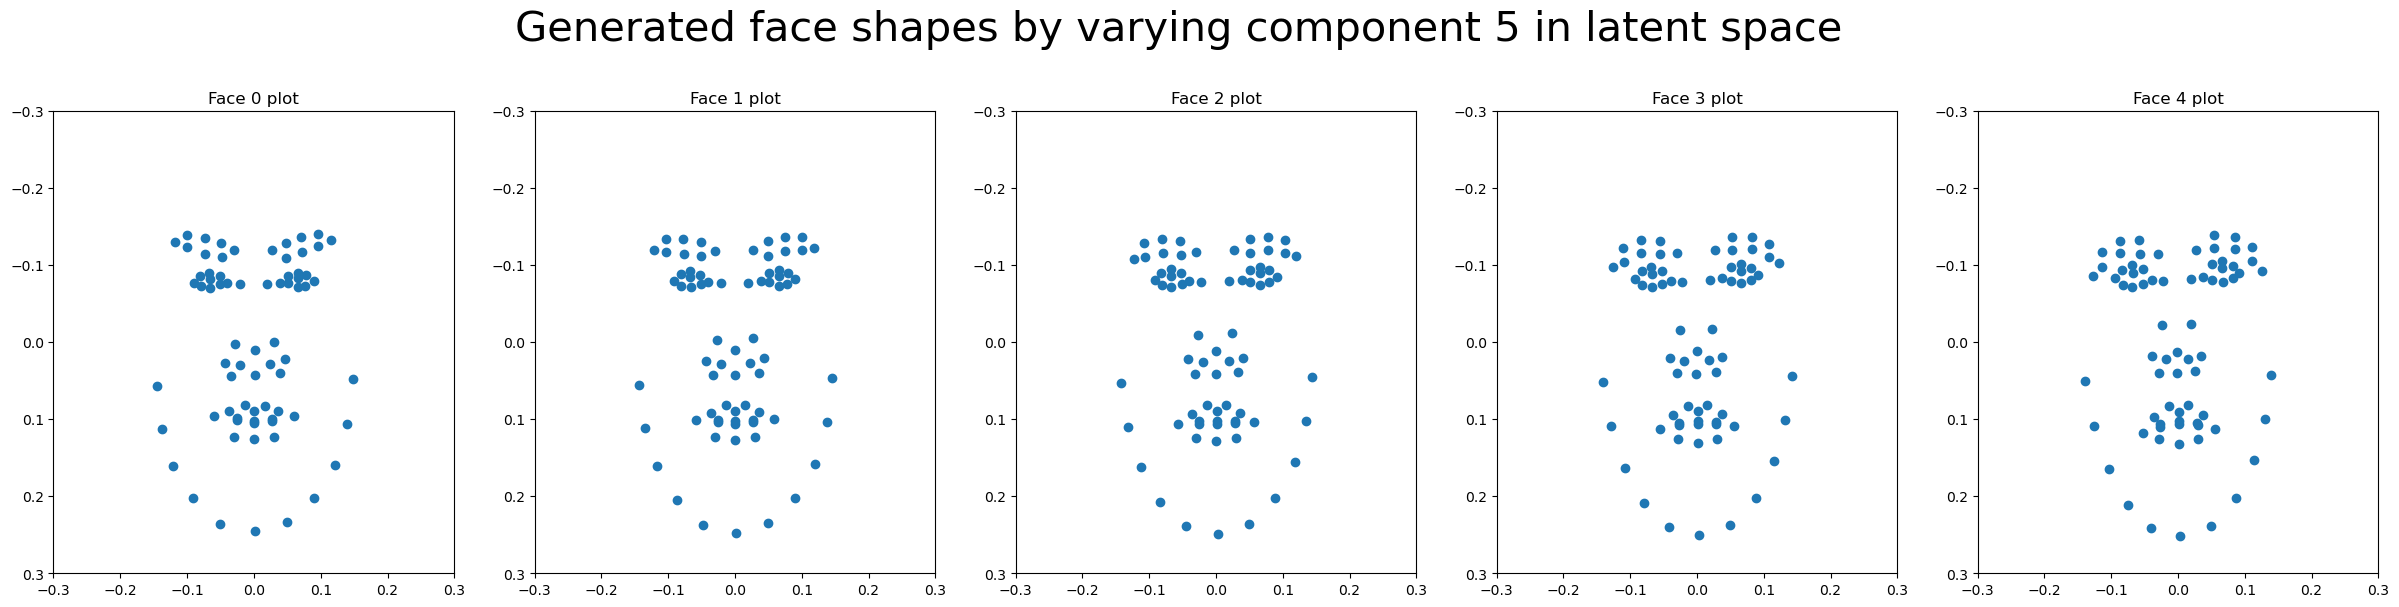

In [23]:
# 1. Varying the 1st Component
# Standard deviation for the first principal component
std_1 = np.sqrt(val[0])

# Generate 5 values for a_1 in the range [-3*std_1, 3*std_1]
a1_values = np.linspace(-3 * std_1, 3 * std_1, num=5)

# Generate faces by varying only the first component
gen_faces_a1 = []
for a1 in a1_values:
    a = np.array([a1, 0, 0, 0, 0])  # Varying only the first component
    face = transform_from_latent_space(a.reshape(1, -1), Phi_k, mu)
    gen_faces_a1.append(face[0])

# Plot the generated faces
plot_many_faces(gen_faces_a1, "Generated face shapes by varying the first coordinate in latent space")


# 2. Repeat for the Remaining Components
# Standard deviations for the remaining principal components
std_values = [np.sqrt(val[i]) for i in range(5)]
gen_faces_all = []

for i in range(5):
    # Generate values for a_i in the range [-3*std_i, 3*std_i]
    ai_values = np.linspace(-3 * std_values[i], 3 * std_values[i], num=5)
    gen_faces_component = []
    
    for ai in ai_values:
        a = np.zeros(5)  # Initialize with zeros
        a[i] = ai  # Set only the i-th component
        face = transform_from_latent_space(a.reshape(1, -1), Phi_k, mu)
        gen_faces_component.append(face[0])
    
    gen_faces_all.append(gen_faces_component)

# Plot faces for each component variation
for idx, faces in enumerate(gen_faces_all):
    plot_many_faces(faces, f"Generated face shapes by varying component {idx+1} in latent space")


## Task 5 reflections

**3. Component Analysis**
* First Component: Likely controls the overall width or elongation of the face, affecting the basic structure.
* Second Component: May influence the vertical length of the face or alter prominent features like the nose or cheekbones.
* Third Component: Could affect the symmetry of facial features or smaller details such as the position of the eyes or mouth.
* Fourth Component: Might adjust finer details in facial contours, such as the jawline.
* Fifth Component: Could impact very subtle features, introducing nuanced changes that become less prominent with each successive component.

## Interpolating between shapes
The following example shows how to interpolate two vectors.


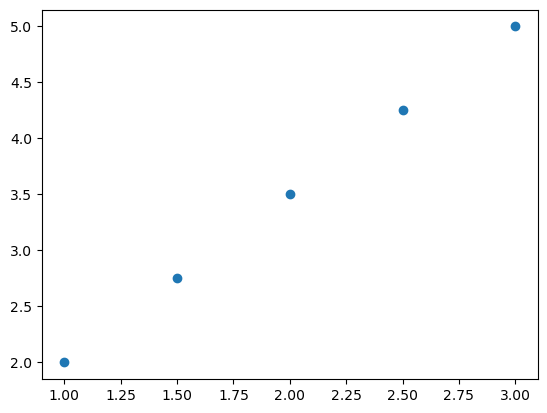

In [24]:
# #Template for doing interpolation between two (2D)- points 
d = np.linspace(np.array([1, 2]), np.array([3, 5]), num=5)
plt.scatter(d[:, 0], d[:, 1])


---
**Task 6 (medium): Interpolation between two faces👩‍💻**
**Shape Interpolation:**
1. Select points $\mathbf{a}$ and $\mathbf{b}$ in latent space (paying attention to the Gaussian constraints) and generate the faces.
2. Use `np.linspace`
 to generate 6 evenly spaced points that interpolate between two vectors, $\mathbf{a}$ and $\mathbf{b}$, in the latent space. Plot the resulting faces. 
3. Select $\mathbf{a}$ and $\mathbf{b}$ such that:    - $\mathbf{a}$ = $[-3\lambda_1,0,-3\lambda_3,0,0]$ and $\mathbf{b}$ = $[3\lambda_1,0,3\lambda_3,0,0]$.
    - $\mathbf{a}$ = $[0,5\lambda_2,0,0,0]$ and $\mathbf{b}$ = $[0,-5\lambda_2,0,0,0]$.
    - the generated shapes represent a smile.




---

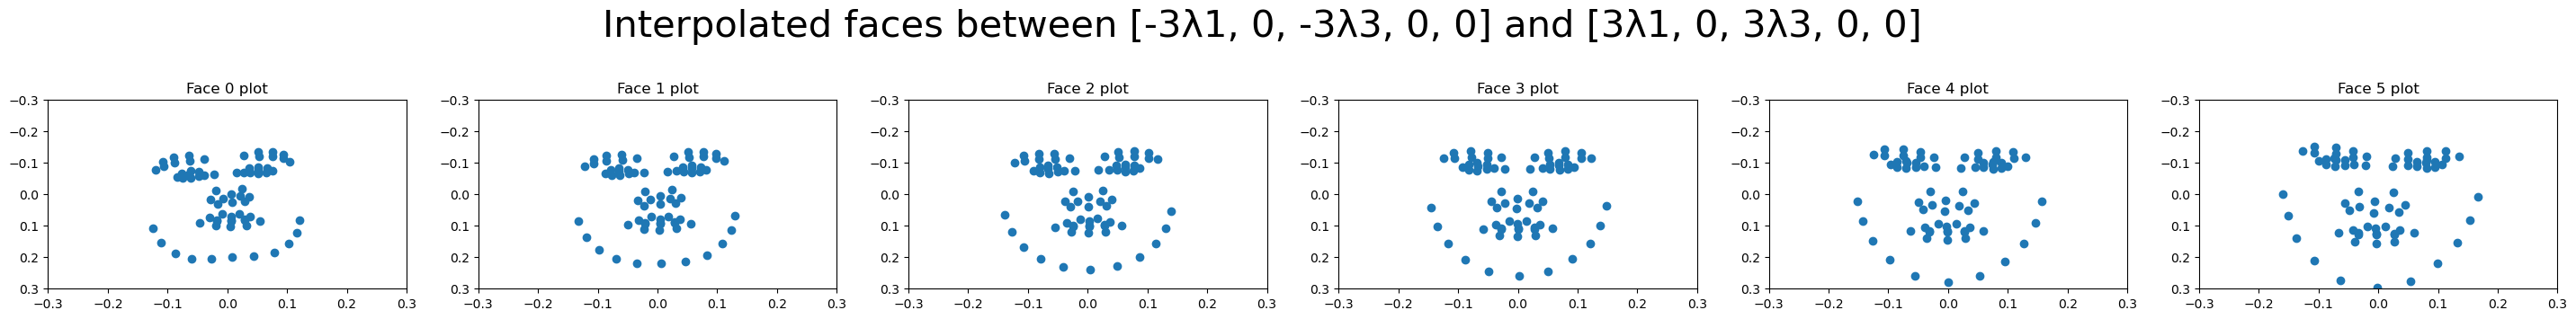

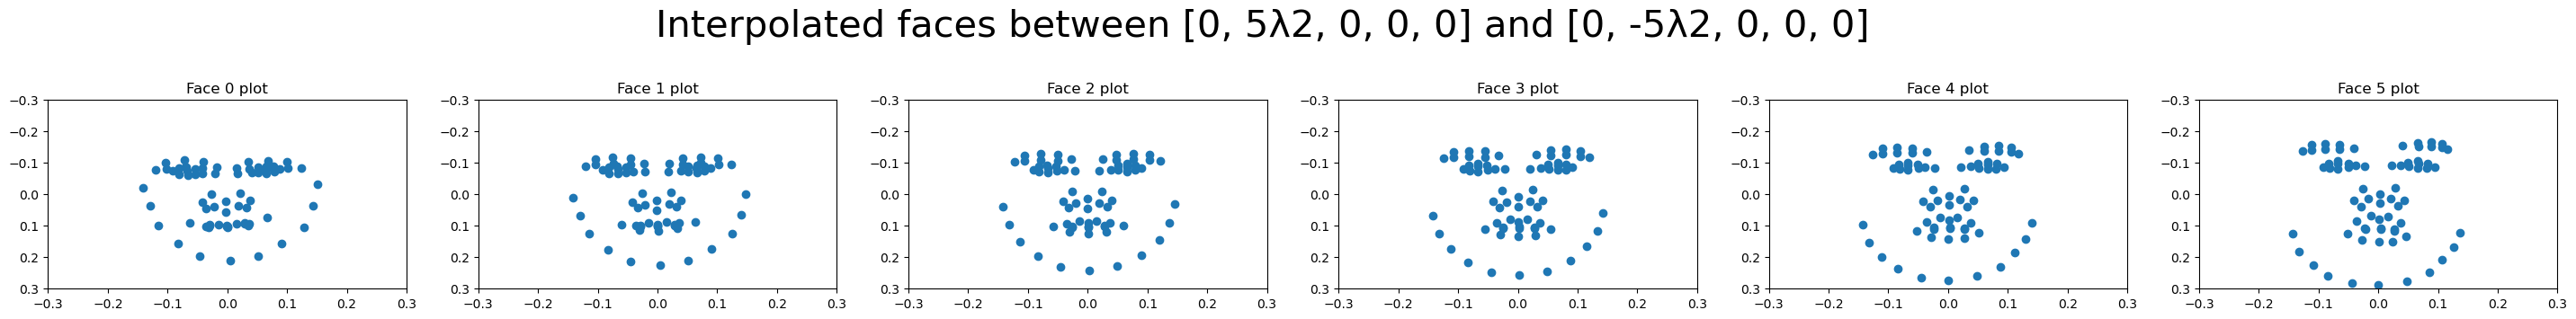

In [25]:
# Standard deviations for each principal component (sqrt of eigenvalues)
std_devs = [np.sqrt(val[i]) for i in range(5)]

# Define the points a and b in latent space for each case
# Case 1: Interpolate between [-3*lambda_1, 0, -3*lambda_3, 0, 0] and [3*lambda_1, 0, 3*lambda_3, 0, 0]
a1 = np.array([-3 * std_devs[0], 0, -3 * std_devs[2], 0, 0])
b1 = np.array([3 * std_devs[0], 0, 3 * std_devs[2], 0, 0])

# Case 2: Interpolate between [0, 5*lambda_2, 0, 0, 0] and [0, -5*lambda_2, 0, 0, 0]
a2 = np.array([0, 5 * std_devs[1], 0, 0, 0])
b2 = np.array([0, -5 * std_devs[1], 0, 0, 0])

# Interpolation and plotting function
def interpolate_and_plot(a, b, title):
    # Generate 6 interpolated points
    interpolated_points = np.linspace(a, b, num=6)
    
    # Generate faces from each interpolated point
    generated_faces = [transform_from_latent_space(point.reshape(1, -1), Phi_k, mu)[0] for point in interpolated_points]
    
    # Plot the generated faces
    plot_many_faces(generated_faces, title)

# Plot interpolated faces for each pair
interpolate_and_plot(a1, b1, "Interpolated faces between [-3λ1, 0, -3λ3, 0, 0] and [3λ1, 0, 3λ3, 0, 0]")
interpolate_and_plot(a2, b2, "Interpolated faces between [0, 5λ2, 0, 0, 0] and [0, -5λ2, 0, 0, 0]")



---
**Task 7 (medium): Reflection💡**
Describe and reflect on the results obtained from this assignment, the exercises and the in-class exercises. Answer the following questions:
1. **Behaviour:** Explain why, a set of points interpolated on a line in latent space corresponds to a sample on a line in data space using $x = \Phi\mathbf{a} + \mu$. 
2. How well can a few principal components reproduce the samples? What happens with the generated data when the number of components $k$ is changed to 1,3,9, or 15?


---

**1. Behavior of Interpolated Points in Latent Space**

Interpolating between points 
a and b in latent space forms a line in data space due to the linear transformation x=Φa+μ. 
Each point along the line in latent space maps to a corresponding point on a line in data space, resulting in smooth transitions between shapes.

**2. Effectiveness of Principal Components and Impact of  k Values**
* k=1: Captures only the main variance direction, resulting in basic, average-like faces without detailed features.
* k=3: Adds some detail but still lacks fine features, representing general facial shape.
* k=9: Retains most major features, producing faces that closely resemble the originals with good detail.
* k=15: Provides a highly accurate reconstruction, closely matching original faces with added finer details.

In summary, low k values capture general shape, while higher  k values add detailed features, illustrating PCA's effectiveness in retaining essential structure with reduced dimensionality.

## Last section - optional
This final section includes three tasks that offer valuable insights into the application of PCA, however completing this section is optional.

---
**Task 8 (medium): Eigenvalues and eigenvectors of correlation matrix _(optional)_👩‍💻💡**
1. Implement the function `get_principal_components_correlation`
 according to the comments in the cell below.
2. Use the provided code to display the eigenvalues of the correlation matrix.
3. How do the eigenvalues obtained from the covariance matrix compare to those from the correlation matrix in terms of magnitude and the variance each principal component explains? What does this reveal about the effect of feature scaling on PCA results?


---

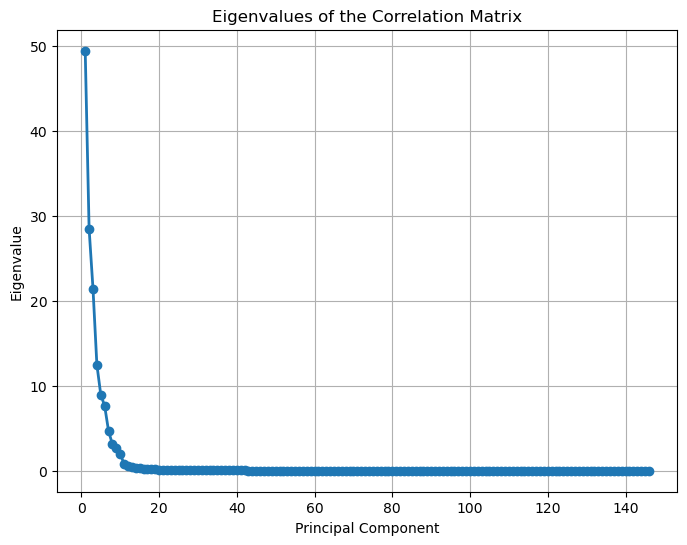

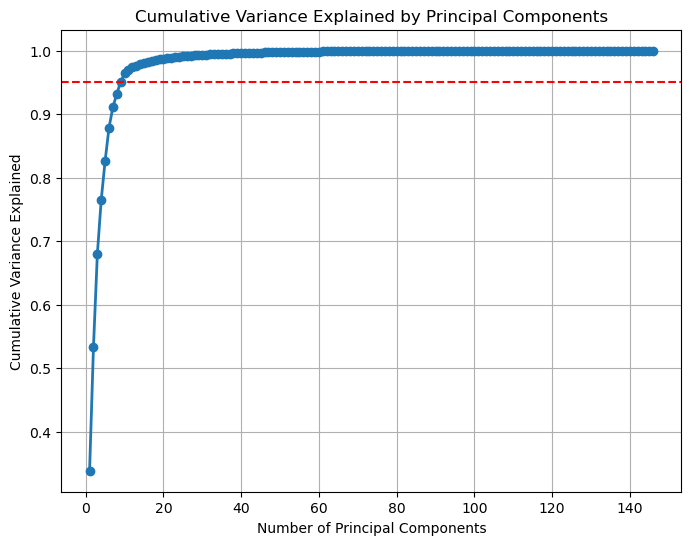

In [26]:
def get_principal_components_correlation(X):
    """Calculates principal components using the correlation matrix for X.

    Args:
        X: The dataset. An NxD array where N are the number of samples and D are
        the number of features.

    Returns:
        Tuple (components, eigenvalues, mu) where components is a DxD matrix of
        principal components, eigenvalues is a D-element vector of
        corresponding eigenvalues, and mu is a D-element array containing the mean
        vector.
    """
    # Standardize the data (subtract mean and divide by standard deviation)
    X_standardized = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

    # Compute the correlation matrix
    correlation_matrix = np.corrcoef(X_standardized, rowvar=False)

    # Compute eigenvalues and eigenvectors of the correlation matrix
    eigenvalues, eigenvectors = np.linalg.eigh(correlation_matrix)

    # Sort eigenvalues and eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    return eigenvectors, eigenvalues, np.mean(X, axis=0)

# Use the function on the shapes data
eigenvectors_corr, eigenvalues_corr, mu_corr = get_principal_components_correlation(shapes)

# Optionally, plot the eigenvalues to see their distribution
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(eigenvalues_corr) + 1), eigenvalues_corr, 'o-', linewidth=2)
plt.title('Eigenvalues of the Correlation Matrix')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.grid(True)
plt.show()

variance_explained = eigenvalues_corr / np.sum(eigenvalues_corr)
cumulative_variance_explained = np.cumsum(variance_explained)

# Plot cumulative variance explained
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance_explained) + 1),
         cumulative_variance_explained, 'o-', linewidth=2)
plt.title('Cumulative Variance Explained by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.axhline(y=0.95, color='r', linestyle='--')  # Line to indicate 90% variance
plt.grid(True)
plt.show()


---
**Task 9 (medium): Dimensionality reduction of features _(optional)_👩‍💻💡**
1. **Transform data:** Use $\mathbf{\Phi^{\top}}$​ to transform the data $\mathbf{x}$ into its latent-space representation $\mathbf{x'}$ (using $\mathbf{x'}= \mathbf{\Phi^{\top}}(\mathbf{x}-\mathbf{\mu})$).
2. Plot the first two  components in latent space using a scatterplot.    - What does this plot tell you about the distribution of faces?
    - Try plotting different pairs of components. Describe how each combination separates (clusters) the dataset differently.


3. **Interpolate between real faces:** Re-implement [Task 6](#interpolate) but instead of selecting 2 points in latent space, transform two real faces to latent space and interpolate between them.     - Plot the faces of the interpolated points.




---

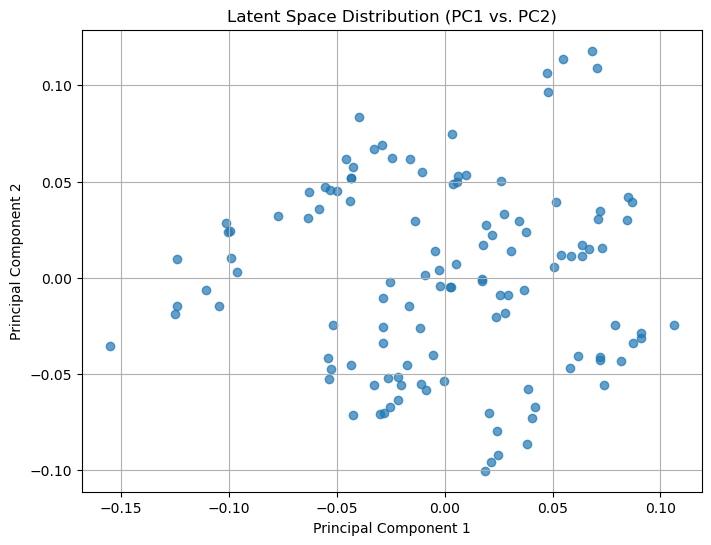

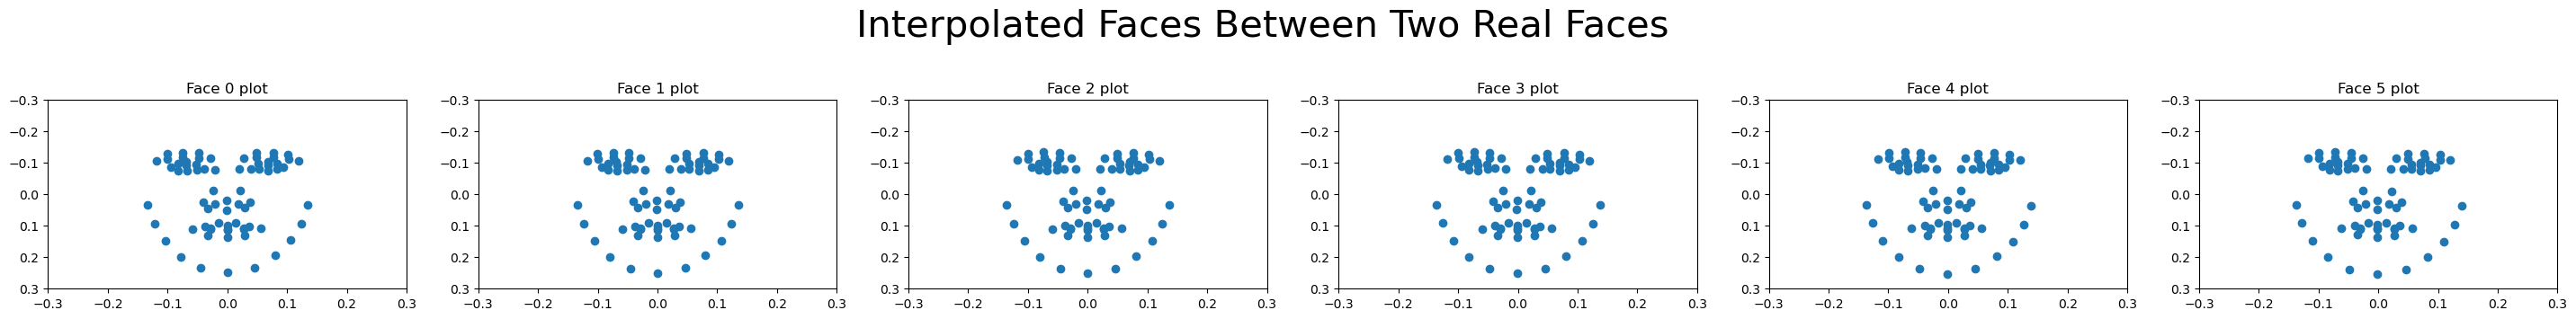

In [27]:
#1. Transform Data to Latent Space
# Use the first few principal components
Phi = comp[:, :5]  # Adjust the number of components as needed

# Transform the data to latent space
shapes_latent = transform_to_latent_space(shapes, Phi, mu)

#2. Plot the First Two Components in Latent Space
# Scatter plot of the first two principal components
plt.figure(figsize=(8, 6))
plt.scatter(shapes_latent[:, 0], shapes_latent[:, 1], alpha=0.7)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Latent Space Distribution (PC1 vs. PC2)")
plt.grid(True)
plt.show()

#3. Interpolate Between Real Faces in Latent Space
# Select two real faces from the dataset
face1 = shapes[0]  # First face
face2 = shapes[1]  # Second face

# Transform the selected faces to latent space
face1_latent = transform_to_latent_space(face1.reshape(1, -1), Phi, mu)
face2_latent = transform_to_latent_space(face2.reshape(1, -1), Phi, mu)

# Interpolate between the two faces in latent space
interpolated_points = np.linspace(face1_latent, face2_latent, num=6)

# Generate faces from interpolated latent space points and plot
generated_faces = [transform_from_latent_space(point.reshape(1, -1), Phi, mu)[0] for point in interpolated_points]
plot_many_faces(generated_faces, "Interpolated Faces Between Two Real Faces")



Describe the different scatter plots of component combinations

---
**Task 10 (medium): Out of distribution generation _(optional)_👩‍💻💡**
1. **Extreme values:** What happens if you select values outside the suggested range. Explain why this happens.


---

## Task 10 reflection

**Effect of Selecting Values Outside the Suggested Range:**

When selecting values for the latent space vector 'a' outside the recommended range [−3σ,3σ], generated faces can look unrealistic or distorted. This occurs because PCA assumes a normal distribution within each principal component's direction. Values beyond ±3σ fall outside the 99.7% data range, pushing the shape outside the learned distribution.